In [1]:
import datetime
import itertools
import os
import re
from collections import deque

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import talib
from matplotlib import dates as mdates
from scipy.interpolate import make_smoothing_spline

## Matplotlib の設定（省略可）

In [2]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

In [3]:
# date_str = "ticks_20251006.xlsx"
file = "ticks_20251118.xlsx"
body = os.path.splitext(os.path.basename(file))[0]
path_excel = os.path.join("..", "collection", file)
code = "7011"

dt = datetime.datetime.now()
date_str = f"{dt.year:04d}{dt.month:02d}{dt.day:02d}"

path_png_1 = f"{date_str}_{body}_{code}_raw_rsi.png"
path_png_2 = f"{date_str}_{body}_{code}_smoothed_rsi.png"

## ティックデータの読込

In [4]:
df = pd.read_excel(path_excel, sheet_name=code)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(ts) for ts in df["Time"]])
df1 = df.copy()
df

,Time,Price,Volume
2025-11-18 09:00:03.364127,1.763424e+09,4150,789100
2025-11-18 09:00:04.364871,1.763424e+09,4150,789100
2025-11-18 09:00:05.372448,1.763424e+09,4150,875200
2025-11-18 09:00:06.371901,1.763424e+09,4150,875200
2025-11-18 09:00:07.378177,1.763424e+09,4148,916000
...,...,...,...
2025-11-18 15:24:55.252227,1.763447e+09,4031,23219600
2025-11-18 15:24:56.257445,1.763447e+09,4032,23221200
2025-11-18 15:24:57.249806,1.763447e+09,4032,23221200
2025-11-18 15:24:58.254269,1.763447e+09,4031,23222900


In [5]:
list_period = [30, 60, 120, 180, 300]
for period in list_period:
    colname = f"RSI_{period:03d}"
    df[colname] = (talib.RSI(df["Price"], timeperiod=period) - 50.0) / 50.0
df

,Time,Price,Volume,RSI_030,RSI_060,RSI_120,RSI_180,RSI_300
2025-11-18 09:00:03.364127,1.763424e+09,4150,789100,NaN,NaN,NaN,NaN,NaN
2025-11-18 09:00:04.364871,1.763424e+09,4150,789100,NaN,NaN,NaN,NaN,NaN
2025-11-18 09:00:05.372448,1.763424e+09,4150,875200,NaN,NaN,NaN,NaN,NaN
2025-11-18 09:00:06.371901,1.763424e+09,4150,875200,NaN,NaN,NaN,NaN,NaN
2025-11-18 09:00:07.378177,1.763424e+09,4148,916000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2025-11-18 15:24:55.252227,1.763447e+09,4031,23219600,-0.036914,-0.007130,-0.018334,-0.026768,-0.029611
2025-11-18 15:24:56.257445,1.763447e+09,4032,23221200,0.120265,0.066316,0.018441,-0.001860,-0.014475
2025-11-18 15:24:57.249806,1.763447e+09,4032,23221200,0.120265,0.066316,0.018441,-0.001860,-0.014475
2025-11-18 15:24:58.254269,1.763447e+09,4031,23222900,-0.036097,-0.008465,-0.017634,-0.025759,-0.028847


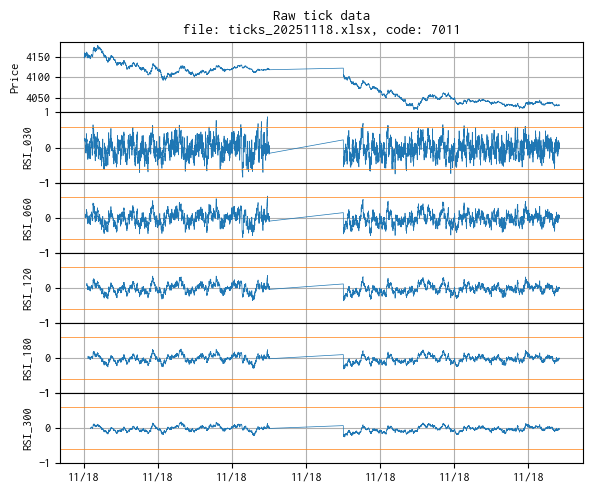

In [6]:
fig = plt.figure(figsize=(6, 5))
n = 1 + len(list_period)
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

colname = "Price"
ax[0].plot(df[colname], linewidth=0.5)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax[0].set_ylabel(colname)
ax[0].set_title(f"Raw tick data\nfile: {file}, code: {code}")

for i, period in enumerate(list_period):
    colname = f"RSI_{period:03d}"
    ax[i + 1].plot(df[colname], linewidth=0.5)
    ax[i + 1].set_ylabel(colname)
    ax[i + 1].set_ylim(-1, 1)
    ax[i + 1].axhline(0.6, linewidth=0.5, color="C1")
    ax[i + 1].axhline(-0.6, linewidth=0.5, color="C1")

plt.tight_layout()
plt.savefig(path_png_1)
plt.show()

# スムージングの利用

In [7]:
deque_x = deque(maxlen=300)
deque_price = deque(maxlen=300)
list_sp = list()
for i, t in enumerate(df1.index):
    price = df1.at[t, "Price"]
    deque_x.append(i)
    deque_price.append(float(price))
    if len(deque_price) < 5:
        list_sp.append(float(price))
    else:
        spl = make_smoothing_spline(deque_x, deque_price, lam=10**6)
        list_sp.append(float(spl(i)))
df1["PriceS"] = list_sp
df1

,Time,Price,Volume,PriceS
2025-11-18 09:00:03.364127,1.763424e+09,4150,789100,4150.000000
2025-11-18 09:00:04.364871,1.763424e+09,4150,789100,4150.000000
2025-11-18 09:00:05.372448,1.763424e+09,4150,875200,4150.000000
2025-11-18 09:00:06.371901,1.763424e+09,4150,875200,4150.000000
2025-11-18 09:00:07.378177,1.763424e+09,4148,916000,4148.800000
...,...,...,...,...
2025-11-18 15:24:55.252227,1.763447e+09,4031,23219600,4031.387606
2025-11-18 15:24:56.257445,1.763447e+09,4032,23221200,4031.425094
2025-11-18 15:24:57.249806,1.763447e+09,4032,23221200,4031.461502
2025-11-18 15:24:58.254269,1.763447e+09,4031,23222900,4031.453104


In [8]:
list_period = [30, 60, 120, 180, 300]
for period in list_period:
    colname = f"RSI_{period:03d}"
    df1[colname] = (talib.RSI(df1["PriceS"], timeperiod=period) - 50.0) / 50.0
df1

,Time,Price,Volume,PriceS,RSI_030,RSI_060,RSI_120,RSI_180,RSI_300
2025-11-18 09:00:03.364127,1.763424e+09,4150,789100,4150.000000,NaN,NaN,NaN,NaN,NaN
2025-11-18 09:00:04.364871,1.763424e+09,4150,789100,4150.000000,NaN,NaN,NaN,NaN,NaN
2025-11-18 09:00:05.372448,1.763424e+09,4150,875200,4150.000000,NaN,NaN,NaN,NaN,NaN
2025-11-18 09:00:06.371901,1.763424e+09,4150,875200,4150.000000,NaN,NaN,NaN,NaN,NaN
2025-11-18 09:00:07.378177,1.763424e+09,4148,916000,4148.800000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-11-18 15:24:55.252227,1.763447e+09,4031,23219600,4031.387606,0.525784,0.243758,0.008643,-0.078241,-0.117519
2025-11-18 15:24:56.257445,1.763447e+09,4032,23221200,4031.425094,0.546254,0.257659,0.016493,-0.072849,-0.114318
2025-11-18 15:24:57.249806,1.763447e+09,4032,23221200,4031.461502,0.565114,0.270895,0.024062,-0.067636,-0.111217
2025-11-18 15:24:58.254269,1.763447e+09,4031,23222900,4031.453104,0.549745,0.265602,0.022233,-0.068686,-0.111789


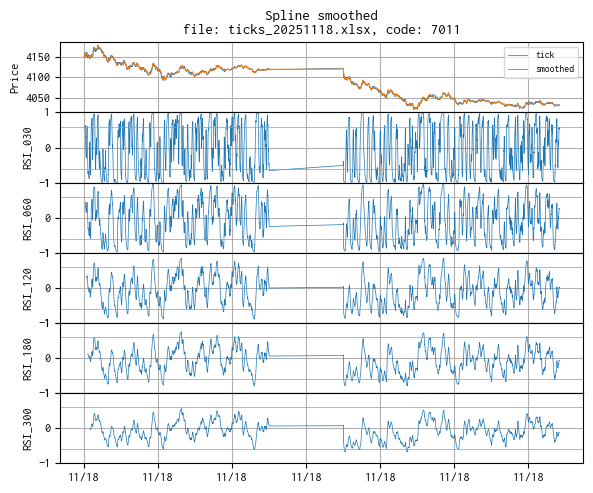

In [9]:
fig = plt.figure(figsize=(6, 5))
n = 1 + len(list_period)
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

colname = "Price"
colname2 = "PriceS"
ax[0].plot(df1[colname], linewidth=0.5, color="C0", label="tick")
ax[0].plot(df1[colname2], linewidth=0.75, color="C1", label="smoothed")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax[0].set_ylabel(colname)
ax[0].legend(fontsize=7)
ax[0].set_title(f"Spline smoothed\nfile: {file}, code: {code}")

for i, period in enumerate(list_period):
    colname = f"RSI_{period:03d}"
    ax[i + 1].plot(df1[colname], linewidth=0.5)
    ax[i + 1].set_ylabel(colname)
    ax[i + 1].set_ylim(-1, 1)
    ax[i + 1].axhline(0.6, linewidth=0.5, color="C1")
    ax[i + 1].axhline(-0.6, linewidth=0.5, color="C1")

plt.tight_layout()
plt.savefig(path_png_2)
plt.show()

In [10]:
period = 60
n = len(deque_price)
list_x = list(itertools.islice(deque_x, n - period - 1, n))
list_y = list(itertools.islice(deque_price, n - period - 1, n))
spl = make_smoothing_spline(list_x, list_y, lam=10**6)
len(list_y), list_y[60], spl(list_x[60])

(61, 4031.0, array(4031.47797177))